# System Identification Example from CasADi Documentation

Adapted from the code here:

  -  https://github.com/casadi/casadi/blob/main/docs/examples/python/sysid.py

In [1]:
from casadi import MX, DM, Function, Importer
import casadi as cas
import numpy as np
import matplotlib.pyplot as plt

In this example,  we fit a nonlinear model to measurements.

This example uses more advanced constructs than the Van der Pol (VDP) system examples:
Since the number of control intervals is potentially very large here, 
we use the memory-efficient `map` and `mapaccum` functions, in combination with 
automatic code generation.

We will be working with a 2-norm objective:
$$|| \mathbf{y}_\text{measured} - \mathbf{y}_\text{simulated} ||_2^2$$

This form is well-suited for the [Gauss-Newton Hessian approximation](https://en.wikipedia.org/wiki/Gauss–Newton_algorithm).

In [2]:
# Settings
N = 10000  # Number of samples
fs = 610.1  # Sampling frequency [hz]

param_truth = DM([5.625e-6, 2.3e-4, 1, 4.69])
param_guess = DM([5, 2, 1, 5])
scale = cas.vertcat(1e-6, 1e-4, 1, 1)

# Modelling
y = MX.sym('y')
dy = MX.sym('dy')
u = MX.sym('u')

states = cas.vertcat(y, dy)
controls = u

M = MX.sym("M")
c = MX.sym("c")
k = MX.sym("k")
k_NL = MX.sym("k_NL")

params = cas.vertcat(M, c, k, k_NL)

rhs = cas.vertcat(dy, (u - k_NL * y**3 - k * y - c * dy) / M)

# Form an ODE function
ode = Function('ode', [states, controls, params], [rhs])

## Creating a Simulator

In [3]:
N_steps_per_sample = 10
dt = 1 / fs / N_steps_per_sample

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = ode(states, controls, params)
k2 = ode(states + dt / 2.0 * k1, controls, params)
k3 = ode(states + dt / 2.0 * k2, controls, params)
k4 = ode(states + dt * k3, controls, params)
states_final = states + dt / 6.0 * (k1 + 2 * k2 + 2 * k3 + k4)

# Create a function that simulates one step propagation in a sample
one_step = Function('one_step', [states,  controls,  params], [states_final])

X = states
for i in range(N_steps_per_sample):
    X = one_step(X, controls, params)

# Create a function that simulates all step propagation on a sample
one_sample = Function('one_sample', [states,  controls,  params],  [X])

# Simulating the system
all_samples = one_sample.mapaccum("all_samples", N)

# Choose an excitation signal
np.random.seed(0)
u_data = DM(0.1 * np.random.random(N))

x0 = DM([0, 0])
X_measured = all_samples(x0, u_data, cas.repmat(param_truth, 1, N))

y_data = X_measured[0, :].T

# You may add some noise here
#y_data + = 0.001 * np.random.random(N)
# When noise is absent, the fit will be perfect.

# Use just-in-time compilation to speed up the evaluation
if Importer.has_plugin('clang'):
    with_jit = True
    compiler = 'clang'
elif Importer.has_plugin('shell'):
    with_jit = True
    compiler = 'shell'
else:
    print("WARNING: running without jit. This may result in very slow evaluation times")
    with_jit = False
    compiler = ''

# Create a Gauss-Newton solver
def gauss_newton(e, nlp, V):
    J = cas.jacobian(e, V)
    H = cas.triu(J.T @ J)
    sigma = MX.sym("sigma")
    hessLag = Function(
        'nlp_hess_l', 
        {'x': V, 'lam_f': sigma, 'hess_gamma_x_x': sigma * H}, 
        ['x', 'p', 'lam_f', 'lam_g'],
        ['hess_gamma_x_x'], 
        dict(jit=with_jit, compiler=compiler)
    )
    return cas.nlpsol("solver", "ipopt", nlp, dict(hess_lag=hessLag, jit=with_jit, compiler=compiler))

## Identifying the simulated system

### 1. Single shooting strategy

In [4]:
# Note, it is in general a good idea to scale your decision variables such
# that they are in the order of ~0.1..100
X_symbolic = all_samples(x0, u_data, cas.repmat(params * scale, 1, N))

e = y_data - X_symbolic[0, :].T
nlp = {'x': params, 'f': 0.5 * cas.dot(e, e)}

solver = gauss_newton(e, nlp,  params)

sol = solver(x0=param_guess)

print(f"Parameters\n estimates: {sol['x'] * scale}")
print(f" true values: {param_truth}")

assert(cas.norm_inf(sol["x"] * scale - param_truth) < 1e-8)

CasADi - 2024-06-23 20:32:09 WARNING("Failed to remove tmp_casadi_compiler_shell4i0u8w.dll") [.../casadi/solvers/shell_compiler.cpp:66]


RuntimeError: Error in Function::Function for 'nlp_hess_l' [MXFunction] at .../casadi/core/function.cpp:280:
.../casadi/core/function_internal.cpp:154: Error calling MXFunction::finalize for 'nlp_hess_l':
.../casadi/solvers/shell_compiler.cpp:231: Compilation failed. Tried "cl.exe /c jit_tmpked7zi.c /Fotmp_casadi_compiler_shell4i0u8w.obj"

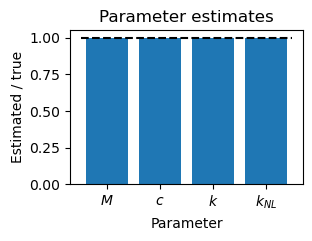

In [ ]:
def estimate_comparison_plot(estimates, true_values, param_names, figsize=(3, 2)):
    plt.figure(figsize=figsize)
    plt.bar(param_names, estimates / true_values)
    plt.hlines(1.0, -0.5, 3.5, linestyle='--', color='k')
    plt.title('Parameter estimates')
    plt.ylabel('Estimated / true')
    plt.xlabel('Parameter')
    plt.show()

param_names = ['$M$', '$c$', '$k$', '$k_{NL}$']
param_estimates = np.array(sol['x'] * scale).reshape(-1)
param_true_values = np.array(param_truth).reshape(-1)
estimate_comparison_plot(param_estimates, param_true_values, param_names)

### 2. Multiple shooting strategy

In [ ]:
# All states become decision variables
X = MX.sym("X", 2, N)

Xn = one_sample.map(N, 'openmp')(X, u_data.T, repmat(params * scale, 1, N))

gaps = Xn[:, : - 1] - X[:, 1:]

e = y_data - Xn[0, :].T

V = cas.veccat(params,  X)

nlp = {'x': V, 'f': 0.5 * cas.dot(e, e), 'g': cas.vec(gaps)}

# Multipleshooting allows for careful initialization
yd = np.diff(y_data, axis=0) * fs
X_guess = cas.horzcat(y_data, cas.vertcat(yd, yd[ - 1])).T

x0 = cas.veccat(param_guess, X_guess)

solver = gauss_newton(e, nlp,  V)

sol = solver(x0=x0, lbg=0, ubg=0)

print(sol["x"][:4] * scale)

assert(cas.norm_inf(sol["x"][:4] * scale - param_truth) < 1e-8)

CasADi - 2024-06-13 17:33:30 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]
CasADi - 2024-06-13 17:33:31 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]
CasADi - 2024-06-13 17:33:33 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]
CasADi - 2024-06-13 17:33:33 WARNING("CasADi was not compiled with WITH_OPENMP=ON. Falling back to serial evaluation.") [.../casadi/core/map.cpp:404]


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   139986
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   110010

Total number of variables............................:    20004
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:    19998
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.6523348e+00 3.64e+01 2.90e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

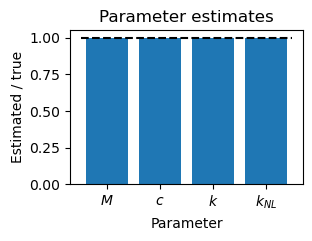

In [ ]:
param_names = ['$M$', '$c$', '$k$', '$k_{NL}$']
param_estimates = np.array(sol["x"][:4] * scale).reshape(-1)
param_true_values = np.array(param_truth).reshape(-1)
estimate_comparison_plot(param_estimates, param_true_values, param_names)